## Описание признаков

* age: возраст в годах
* sex: пол (1 - мужской, 2 - женский)
* cp: тип боли в груди (0 - типичная стенокардия, 1 - нетипичная стенокардия, 2 - боль не свойственная при стенокардии, 3 - отстуствие болей)
* trestbps: артериальное давление в состоянии покоя
* chol: сывороточный холестерин в мг/дл
* fbs: (<уровень_сахара_в_крови_натощак> > 120 мг/дл) (1 = истина; 0 = ложь)
* restecg: результаты электрокардиографии в состоянии покоя (0 - в норме, 1 - наличие аномалии зубца ST-T, 2 - наличие вероятной или определенной гипертрофии левого желудочка по критериям Эстеса)
* thalach: максимальная частота сердечных сокращений
* exang: стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
* oldpeak: Депрессия ST ("снижение" на графике), вызванная физической нагрузкой по сравнению с отдыхом
* slope: наклон сегмента ST пикового упражнения (0 - наклоненный вверх,
1 - плоский, 2 - наклоненный вниз)
* ca: количество крупных сосудов (0-3), окрашенных флуороскопией
* thal: (0 - в норме, 1 - исправленый дефект, 2 - обратимый дефект)
* condition: диагноз (0 - здоров, 1 - болен)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = '../data/heart_cleveland_upload.csv'
df = pd.read_csv(path)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


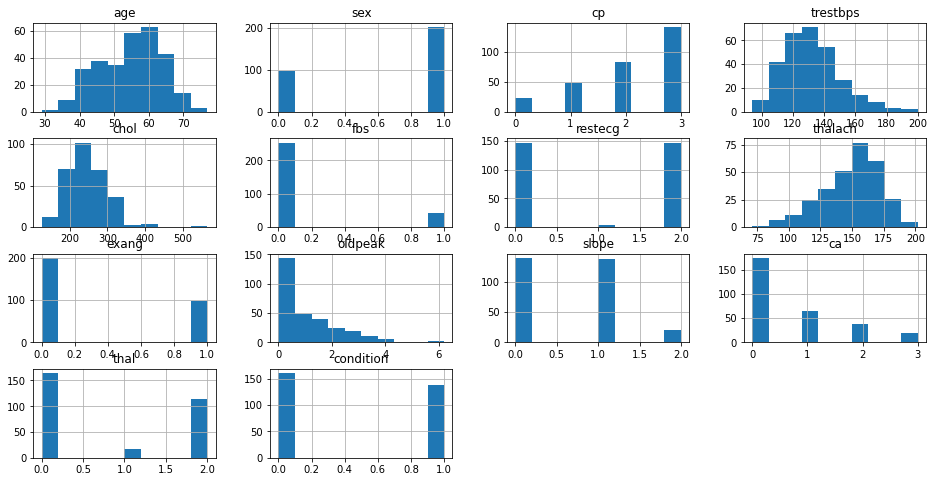

In [3]:

cat_features = ['cp', 'slope', 'thal']
num_features = ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca']
target = ['condition']

df.hist(figsize = (16, 8))
None

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


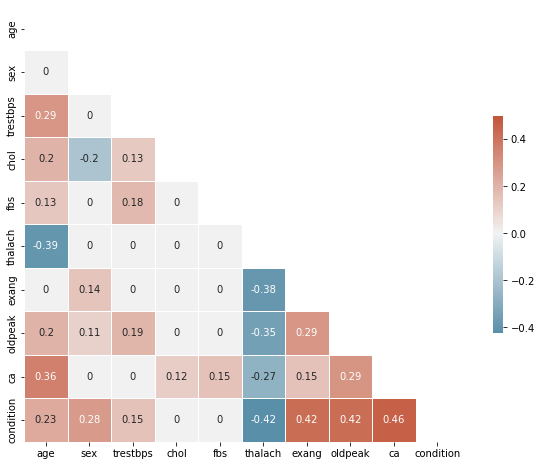

In [6]:
corr = df[num_features + target].corr()
corr[np.abs(corr) < 0.1] = 0
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize = (12, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [8]:
y = df[target]
x = df[num_features + cat_features]

x_train, x_valid, y_train, y_valid = train_test_split(x, y, stratify=y)

In [9]:
cat_transformer = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('StadardScaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num_features', num_transformer, num_features),
        ('cat_features', cat_transformer, cat_features)],
    sparse_threshold = 0)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('SVM', SVC(C=1, kernel='rbf', degree=3, random_state=42, class_weight='balanced', probability=True))
])

In [10]:
model.fit(x_train, y_train)

/home/andrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num_features',
                                                  Pipeline(steps=[('StadardScaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sex', 'trestbps',
                                                   'chol', 'fbs', 'thalach',
                                                   'exang', 'oldpeak', 'ca']),
                                                 ('cat_features',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cp', 'slope', 'thal'])])),
                ('SVM',
                 SVC(C=1, class_weight='balanced', probability=True,
         

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

pred_train = model.predict(x_train)
pred_valid = model.predict(x_valid)

train_accuracy = accuracy_score(pred_train, y_train)
valid_accuracy = accuracy_score(pred_valid, y_valid)

train_recall = recall_score(pred_train, y_train)
valid_recall = recall_score(pred_valid, y_valid)

train_precision = precision_score(pred_train, y_train)
valid_precision = precision_score(pred_valid, y_valid)
print('accuracy train:\n {:.3f}  valid: {:.3f}\n'.format(train_accuracy, valid_accuracy))
print('recall train:\n {:.3f}  valid: {:.3f}\n'.format(train_recall, valid_recall))
print('precision train:\n {:.3f}  valid: {:.3f}\n'.format(train_precision, valid_precision))

accuracy train:
 0.932  valid: 0.733

recall train:
 0.931  valid: 0.703

precision train:
 0.922  valid: 0.743

